In [1]:
from quadmodel.quadmodel import QuadLensSystem   
from quadmodel.deflector_models.power_law_shear import PowerLawShear
from quadmodel.macromodel import MacroLensModel
from quadmodel.data import Quad as LensedQuasar
from quadmodel.deflector_models.sis import SIS
from quadmodel.Solvers.hierachical import HierarchicalOptimization
from quadmodel.Solvers.brute import BruteOptimization

from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

from pyHalo.preset_models import CDM
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

### First set up the lens model and create the population of dark matter halos with pyHalo

You can pass several keyword arguments into the CDM function that affect the number and abundance of dark matter halos generated. In particular, the parameter sigma_sub determines the number of subhalos around the lensing galaxy, and the parameter delta_power_law_index changes the slope of the halo mass function.

In [3]:
zlens = 0.45
zsource = 3.69
x_image = np.array([-0.347, -0.734, -1.096, 0.207])
y_image = np.array([ 0.964,  0.649, -0.079, -0.148])
magnifications = np.array([[0.88, 1.,  0.474, 0.025]])
data = LensedQuasar(x_image, y_image,  magnifications)

sigma_sub = 0.05
delta_power_law_index = 0. # 0 means no change to the CDM prediction
realization = CDM(zlens, zsource, sigma_sub=sigma_sub, delta_power_law_index=delta_power_law_index)
print('realization contains '+str(len(realization.halos))+' halos')

# these parameters describe the main deflector lens model; the way you initialize them is arbitrary
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': -0.0, 'e1': 0.1, 'e2': 0.2, 'gamma': 2.0}, 
               {'gamma1': 0.0, 'gamma2': 0.0}]

main_lens_fit = PowerLawShear(zlens, kwargs_macromodel)
macromodel = MacroLensModel([main_lens_fit])
lens_system = QuadLensSystem.shift_background_auto(data, macromodel, zsource, realization)

realization contains 9357 halos


### Fit a lens model

Now we adjust the parameters describing the mass profile of the main deflector ("kwargs_macromodel") so that we get a lens system with the same image positions as in the data with the halos included in the lens model.

In [4]:
verbose = True # verbose controls how much stuff gets printed to screen
# this will print the output from the fitting process. Set it to False to save space if you want
optimizer = HierarchicalOptimization(lens_system)
kwargs_lens_final, lens_model_full, return_kwargs = optimizer.optimize(data, constrain_params=None,
                                                   param_class_name='free_shear_powerlaw',
                                                                       verbose=verbose)

optimization 1
aperture size:  100
minimum mass in aperture:  7.0
minimum global mass:  7.0
N foreground halos:  74
N subhalos:  392
10
20
30
40
50
60
70
PSO done... 
source plane chi^2:  67886.08871859928
total chi^2:  67886.08871859928
starting amoeba... 
optimization done.
Recovered source position:  (array([-0.35284045, -0.35284068, -0.35284047, -0.3528404 ]), array([0.26219183, 0.26219201, 0.26219186, 0.26219193]))
optimization 2
aperture size:  0.2
minimum mass in aperture:  0.0
minimum global mass:  7.0
N foreground halos:  84
N subhalos:  445
starting amoeba... 
optimization done.
Recovered source position:  (array([-0.35296109, -0.35296117, -0.35296106, -0.35296116]), array([0.26216193, 0.26216179, 0.26216199, 0.2621621 ]))
optimization 1
nhalos:  771
aperture size:  100
minimum mass in aperture:  7.0
minimum global mass:  7.0
N foreground halos:  84
N subhalos:  445
N background halos:  687
starting amoeba... 
optimization done.
Recovered source position:  (array([-0.34688968

### Compute the flux ratios

With the full lens model, we can compute the flux ratios for any background source model we want. Below, we can compute the flux ratios for two different source sizes. When halos are present near an image, the flux ratios should be a function of the source size. 

[0.84103607 1.         0.56192563 0.02974374]
[0.8265112  1.         0.54201147 0.02896615]


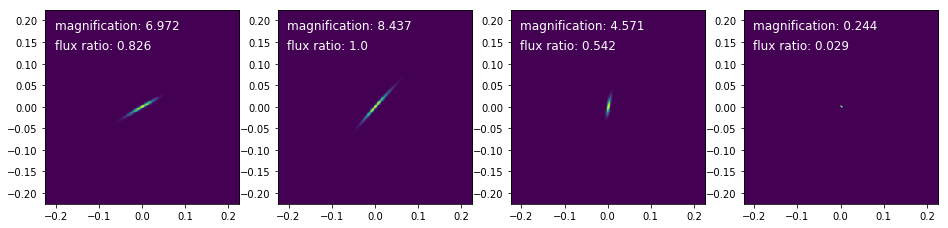

In [6]:
lensmodel, kwargs = lens_system.get_lensmodel()
source_size_small = 1. # parsec
flux_ratios_small_source = lens_system.quasar_magnification(data.x, 
                                     data.y, source_size_small, lens_model=lensmodel, 
                                   kwargs_lensmodel=kwargs, grid_axis_ratio=0.5, 
                                   grid_resolution_rescale=2., source_model='GAUSSIAN')

source_size_large = 45 # parsec
flux_ratios_large_source = lens_system.quasar_magnification(data.x, 
                                     data.y, source_size_large, lens_model=lensmodel, 
                                   kwargs_lensmodel=kwargs, grid_axis_ratio=0.5, 
                                   grid_resolution_rescale=2., source_model='GAUSSIAN')

print(flux_ratios_small_source)
print(flux_ratios_large_source)

# This will ray trace through the lens model and plot what the lensed images look like
lens_system.plot_images(data.x, data.y, source_size_large, lens_model=lensmodel, 
                               kwargs_lensmodel=kwargs, source_model='GAUSSIAN',
                       grid_resolution_rescale=2.)

### Visualize the result

We can visualize the lens system created in the model by plotting the image positions and critical curves on top of the effective multiplane convergence from substructure

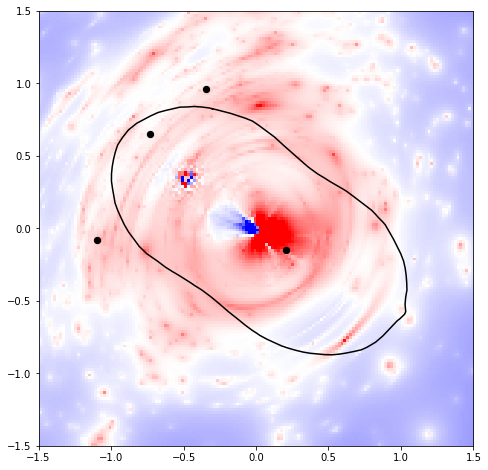

In [8]:
lens_system_smooth = lens_system.get_smooth_lens_system()
lensmodel_smooth, kwargs_smooth = lens_system_smooth.get_lensmodel()

npix = 150
ran = 1.5
extension = LensModelExtensions(lensmodel)
ra_crit_list, dec_crit_list, ra_caustic_list, dec_caustic_list = extension.critical_curve_caustics(kwargs, 
                                                             compute_window=2*ran, grid_scale=0.05)


_x = np.linspace(-ran, ran, npix)
xx, yy = np.meshgrid(_x, _x)
shape0 = xx.shape
kappa_full = lensmodel.kappa(xx.ravel(), yy.ravel(), kwargs).reshape(shape0)
kappa_macro = lensmodel_smooth.kappa(xx.ravel(), yy.ravel(), kwargs_smooth).reshape(shape0)
substructure_convergence = kappa_full - kappa_macro

fig = plt.figure(1)
fig.set_size_inches(8, 8)
zero_point = np.mean(substructure_convergence)
plt.imshow(substructure_convergence - zero_point, vmin=-0.1, vmax=0.1, cmap='bwr', origin='lower',
          extent=[-ran, ran, -ran, ran])
plt.scatter(data.x, data.y, color='k', s=40)

plt.plot(ra_crit_list[0], dec_crit_list[0], color='k')